In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gudhi
from tqdm import tqdm
from numba import jit

In [2]:
@jit(forceobj=True)
def number_of_b0_b1(p):
    rips = gudhi.RipsComplex(points = p, max_edge_length = 2.5)
    s_tree = rips.create_simplex_tree(max_dimension = 2)
    diag = s_tree.persistence()
    b0, b1 = 0, 0
    for dg in diag:
        if(dg[1][1] >= 1.42 or dg[1][1] == np.inf):
            if(dg[0] == 0):
                b0 += 1
            if(dg[0] == 1):
                b1 += 1
    return b0, b1

In [3]:
@jit(forceobj=True)
def image_to_point(X):
    points = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if(X[i, j] == 0):
                a = np.array([i, j])
                points.append(a)
    points = np.array(points)
    return points

In [4]:
def local_merging_number(X, patches_x, patches_y, step_perc = 0.5, thresh = 1):
    x_b0, x_b1 = number_of_b0_b1(image_to_point(X))

    px_s = (int)(X.shape[0] / patches_x) 
    py_s = (int)(X.shape[1] / patches_y)
    while((X.shape[0] - patches_x * px_s) >= px_s):
      px_s += 1
    while((X.shape[1] - patches_y * py_s) >= py_s):
      py_s += 1
    print(f"{X.shape}, px_s = {px_s}, py_s = {py_s}")
    
    
    Y = np.zeros([X.shape[0], X.shape[1]]) + 255

    offset = 0
    
    lg = np.zeros([patches_x, patches_y])
    olg = np.zeros([patches_x, patches_y])

    step_x = (int)(step_perc * px_s)
    step_y = (int)(step_perc *py_s)
    i, j = 0, 0
    pbar = tqdm(total = X.shape[0] - px_s)
    while(i < (X.shape[0] - px_s)):
      while(j < (X.shape[1] - py_s)):
        X1 = np.zeros([X.shape[0], X.shape[1]]) + 255
        X2 = np.zeros([X.shape[0], X.shape[1]]) + 255
        # print(f"({i + 1} : {i + px_s}), ({j + 1} : {j + py_s}), {offset}")
        X1[ (i + 1) : (i + step_x), (j + 1) : (j + py_s) ] = np.array(X[(i + 1) : (i + step_x), (j + 1) : (j + py_s)])
        x1_b0, x1_b1 = number_of_b0_b1(image_to_point(X1[(i + 1) : (i + step_x), (j + 1) : (j + py_s)]))

        X2 = np.array(X)
        X2[ i : (i + px_s - 1), j : (j + py_s - 1)] = 255
        x2_b0, x2_b1 = number_of_b0_b1(image_to_point(X2))

        if(x_b1 > (x1_b1 + x2_b1)):
          n = (int) (i/px_s)
          m = (int) (j/py_s)
          olg[n, m] += (x_b1 - (x1_b1 + x2_b1))
          if(olg[n, m] >= thresh):
            Y[i : (i + px_s - 1), j : (j + py_s - 1) ] = np.array(X[i : (i + px_s - 1), j : (j + py_s - 1) ])
          # cv2.imwrite(f"./image_Y_{offset}.png", Y)

        # cv2.imwrite(f"./image_X1_{offset}.png", X1[:,:, offset])
        # cv2.imwrite(f"./image_X2_{offset}.png", X2[:,:, offset])
        # cv2.imwrite(f"./image_X1UX2_{offset}.png", X1_U_X2[:,:, offset])
        j += step_y
      j = 0
      i += step_x
      pbar.update(step_x)
    pbar.close()
    return lg,olg, Y

In [5]:
img = cv2.imread('./images/qr-code-7.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,X = cv2.threshold(img,70,255,cv2.THRESH_BINARY)

In [6]:
X.shape

(928, 928)

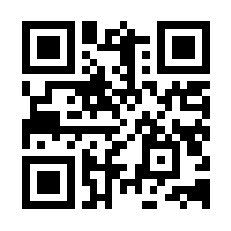

In [7]:
orig_map = plt.cm.get_cmap('Greys')
rev_map = orig_map.reversed()

fig1, ax1 = plt.subplots()
ax1.axis('off')
ax1.imshow(X, cmap = rev_map);

In [8]:
X_ = cv2.resize(X, [(int)(X.shape[0]/5), (int)(X.shape[1]/5)])
X_.shape

(185, 185)

In [9]:
lg_num, olg_num, heat_map = local_merging_number(X_, 10, 10, 0.5)

(185, 185), px_s = 18, py_s = 18


171it [06:17,  2.21s/it]                         


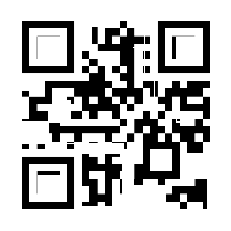

In [10]:
fig3, ax3 = plt.subplots()
ax3.axis('off')
ax3.imshow(heat_map, cmap = rev_map);

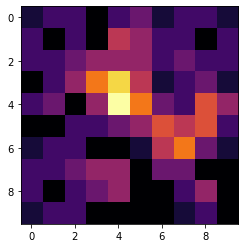

In [11]:
fig4, ax4 = plt.subplots()
ax4.imshow(olg_num, cmap = 'inferno');